## Config

### main library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage as sk

from scipy import ndimage as ndi

import os
%matplotlib inline

### local files

In [3]:
from src import utils,boudingBox, nanoSegmentation, gui
import dearpygui.dearpygui as dpg
import dearpygui.demo as demo



### Notebook interaction

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [5]:
def f(x):
    return x

## Main script

### File loading
First we select a File, we use the TKinter output to select a file, we also define the 

In [9]:
filePath = "img\cherles 2 PEG vrai-25kX-0001.tif"
fileName = os.path.basename(filePath)

#we also define the scaling of the picture

scale = widgets.IntSlider(description='Scale factor',value=5,min=1,max=10)
display(scale)

IntSlider(value=5, description='Scale factor', max=10, min=1)

Now we are going to load the picture in memory and scale it down.<br>
Move the slider above to scale the picture.

(note: you have to reexcute the code bellow to apply the change)

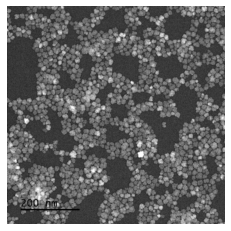

In [10]:
im = utils.openFile(filePath,scale.get_interact_value(),display=True)

### Pre processing
In this part, we perform some préprocessing. This is a very important step in the code and need to be done carfully as it decide the result.

In [12]:
se = widgets.IntSlider(description='SE size',value=5, min=1, max=10)
sigma = widgets.FloatSlider(description='Sigma',value=1.0, min=0.1, max=5.0)

display(se)
display(sigma)

IntSlider(value=5, description='SE size', max=10, min=1)

FloatSlider(value=1.0, description='Sigma', max=5.0, min=0.1)

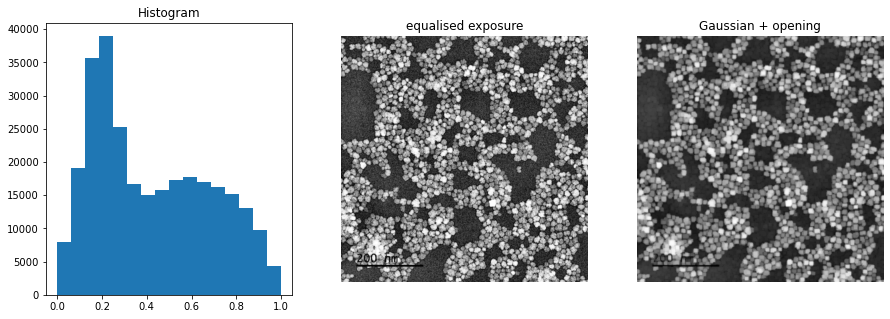

In [13]:
imProcessed = nanoSegmentation.preProcessing(im,se.get_interact_value(),sigma.get_interact_value(),True)

### Distance based watershed

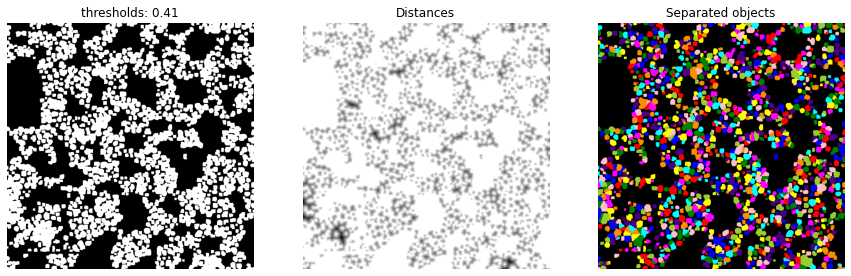

In [15]:
labels, markers = nanoSegmentation.distanceBasedWatershed(imProcessed,True)

### Boudaries

In [27]:
landmarkSizeWg = widgets.FloatSlider(description='Minimum size for a region',value=100, min=50, max=1000)
display(landmarkSizeWg)

FloatSlider(value=100.0, description='Minimum size for a region', max=1000.0, min=50.0)

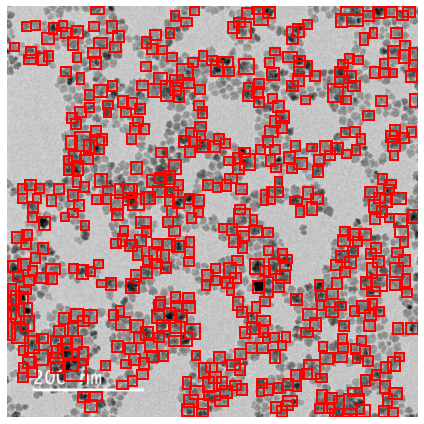

In [28]:
bboxArray = boudingBox.getBoundingBox(255 - im, labels,landmarkSizeWg.get_interact_value(), True)


### Putting everything together

In [16]:
@interact(filePath="img\MNFs 30_6_2022-15kX-0004.tif",imgScale=(1,10),seSize=(1,20),sigmaGaussian=(0.1,5.0,0.1),landmarkSize=(100,1000,25),continuous_update=False)
def segmentation(filePath:str,imgScale:int, seSize:int, sigmaGaussian:float, landmarkSize:int):
    img = utils.openFile(filePath,imgScale,display=True)
    imProcessed = nanoSegmentation.preProcessing(img,seSize,sigmaGaussian,True)
    labels, markers = nanoSegmentation.distanceBasedWatershed(imProcessed,True)
    bboxArray = boudingBox.getBoundingBox(255 - img, labels,landmarkSize, True)
    pass

interactive(children=(Text(value='img\\MNFs 30_6_2022-15kX-0004.tif', description='filePath'), IntSlider(value…